# Exercise 11

- In this exercise we will train a neural net to learn the two spirals dataset from [SyntheticDatasets.jl](https://github.com/ATISLabs/SyntheticDatasets.jl).

In [1]:
using Flux, Plots, SyntheticDatasets

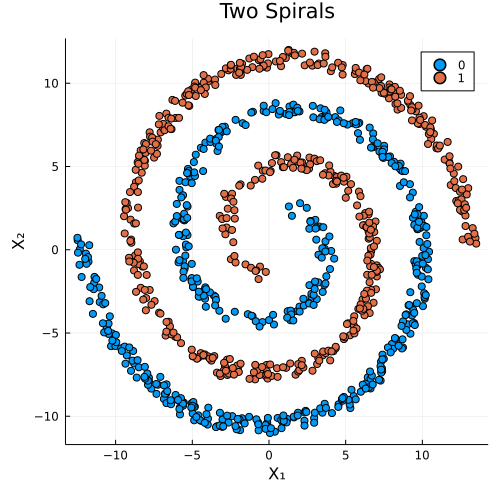

In [2]:
# Generate the data
spirals = SyntheticDatasets.make_twospirals(n_samples = 1000, 
                                            start_degrees = 90,
                                            total_degrees = 630, 
                                            noise = 1.0)

# Convert the dataframe to Julia Arrays
X = [spirals.feature_1, spirals.feature_2]
y = spirals.label

# Plot
scatter(X[1], X[2], group = y, xlabel = "X₁", ylabel = "X₂", title = "Two Spirals", size = (500, 500))

1. Follow Task 1 and Task 2 in this interactive [notebook](https://developers.google.com/machine-learning/crash-course/introduction-to-neural-networks/playground-exercises#neural-net-spiral) to experiment with many different model setups, varying the number of layers, the width of the layers, and the regularisation.

2. Once you're satisfied with your test error for a given model setup, implement and train that model in Julia using Flux. Note that the noise parameters in the notebook and the SyntheticDatasets library are not equivalent, so just try to use values of the parameters which result in visually similar datasets. Remember to split the data into training and test sets. Is the test error of your implementation comparable to the one in the notebook?

## Solution

In [3]:
"""
    get_twospirals_data(n_samples = 1000, start_degrees = 90, total_degrees = 630, noise = 1.0, doplot = true)

Get the two spirals data in the matrix format required by Flux.
"""
function get_twospirals_data(;n_samples = 1000, start_degrees = 90, total_degrees = 630, noise = 1.0, doplot = true)
    spirals = SyntheticDatasets.make_twospirals(n_samples = n_samples, 
                                                start_degrees = start_degrees,
                                                total_degrees = total_degrees, 
                                                noise = noise,
                                                )
    
    X = [reshape(spirals.feature_1, 1, length(spirals.feature_1))
         reshape(spirals.feature_2, 1, length(spirals.feature_2))]
    y = reshape(spirals.label, 1, length(spirals.label))
    
    if doplot
        plt = scatter(X[1, :], X[2, :], group = y[:], xlabel = "X₁", ylabel = "X₂", title = "Two Spirals", size = (500, 500))
        display(plt)
    end
    
    return X, y
end

get_twospirals_data

In [4]:
"""
    plot_training(train_loss, test_loss, epochs)

Plot the training loss and test loss as training progresses.
"""
function plot_training(train_loss, test_loss, epochs)
    plt = plot(
        train_loss, 
        label = "train_loss", 
        xlabel = "epoch", 
        ylabel = "error", 
        size = (800, 500), 
        xlims = (0, epochs), 
        right_margin = 3Plots.mm,
        title = "test_loss = " * string(round(test_loss[end], digits = 2)),
    )
    plot!(plt, test_loss, label = "test_loss")
    IJulia.clear_output(true)  # Clear the old plot
    display(plt)    
end

plot_training

In [5]:
"""
    train_spiral(X, y; epochs = 1000, width = 20, activation = σ, λ = 0.0)

Train a neural net with a single hidden layer on the data in X and y.

We use a sigmoid activation function by default because it saturates at 0 and 1, 
and is therefore suitable for the two spirals data we wish to learn.
"""
function train_spiral(X, y; epochs = 1000, width = 30, activation = σ, λ = 0.0)
    # 1. Feature engineering
    #X = vcat(X, X.^2, sin.(X), (X[1, :] .* X[2, :])')
    
    # 2. Train-test split
    (X_train, y_train), (X_test, y_test) = Flux.splitobs((X, y), at = 0.7, shuffle = true)
    
    # 3. Set up the model
    n_features = size(X)[1]  # Will be 2 unless we do some feature engineering
    hidden_layer = Dense(n_features, width, activation)
    output_layer = Dense(width, 1, activation)
    mlp = Chain(hidden_layer, output_layer)
    
    # 4. Define loss function and regularisation
    L2(θ) = sum(x -> sum(abs2, x), θ)
    loss(X, y) = Flux.mse(mlp(X), y) + λ * L2(Flux.params(mlp))
    
    # 5. Choose an optimiser and a learning rate
    opt = ADAM(0.1)

    # 6. Train
    train_loss = []
    test_loss = []
    for epoch in 1:epochs
        Flux.train!(loss, Flux.params(mlp), [(X_train, y_train)], opt)
        
        # Record and plot the loss
        push!(train_loss, Flux.mse(mlp(X_train), y_train))
        push!(test_loss, Flux.mse(mlp(X_test), y_test))
        plot_training(train_loss, test_loss, epochs)
    end
end

train_spiral

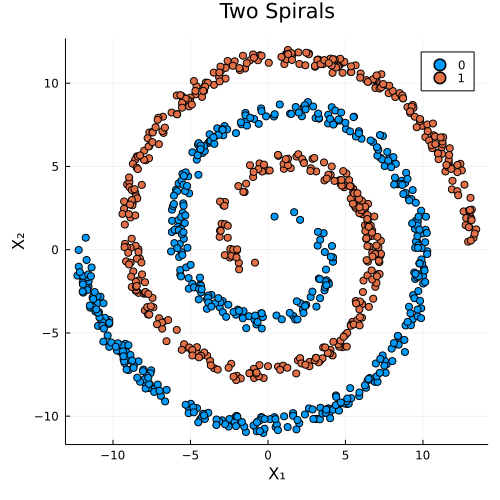

In [12]:
X, y = get_twospirals_data();

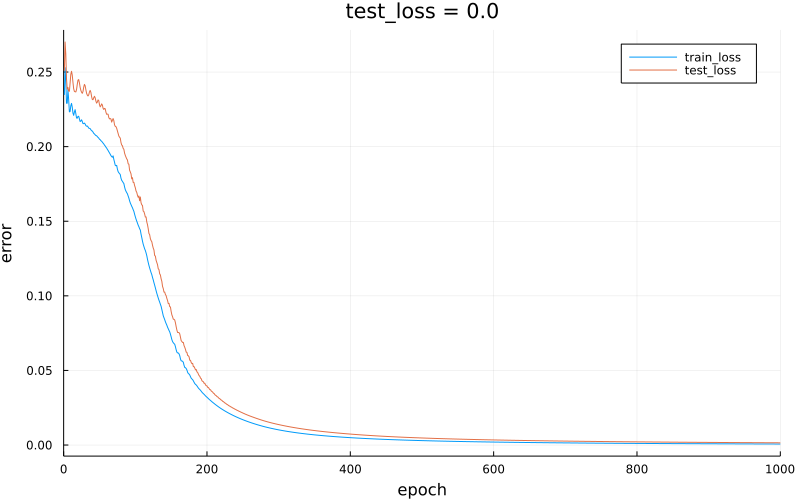

In [7]:
train_spiral(X, y)

Since there's very little noise in the data, the two categories are well separated and we can easily learn to distinguish between them. Let's try adding some noise.

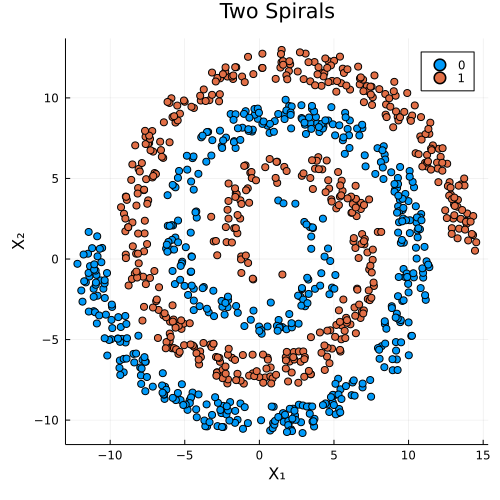

In [17]:
X, y = get_twospirals_data(noise = 2.0);

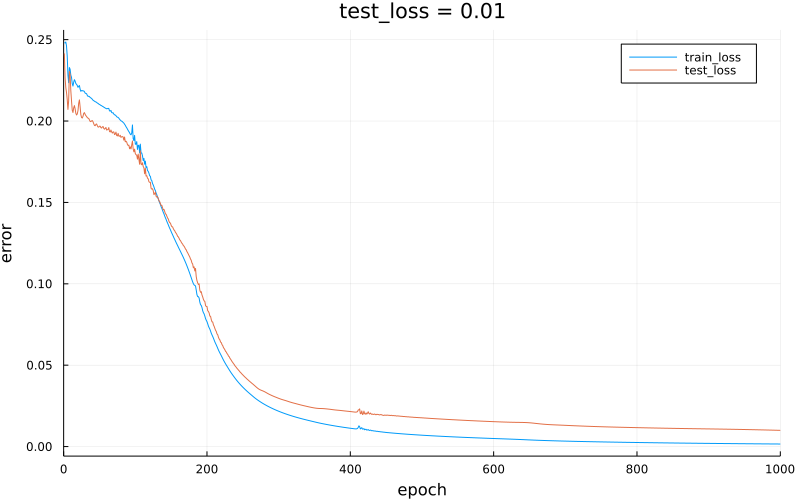

In [9]:
train_spiral(X, y)

This is similar to what we had before. Let's try adding even more noise.

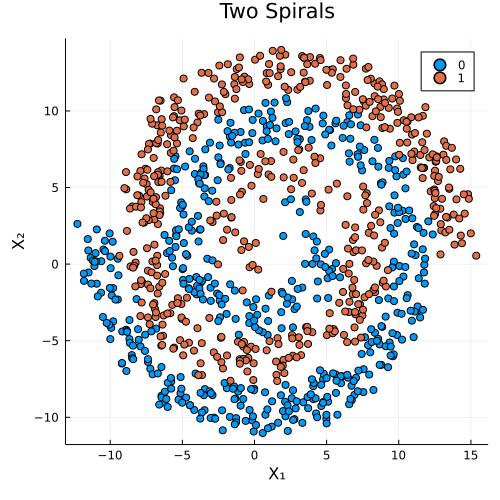

In [20]:
X, y = get_twospirals_data(noise = 3.0);

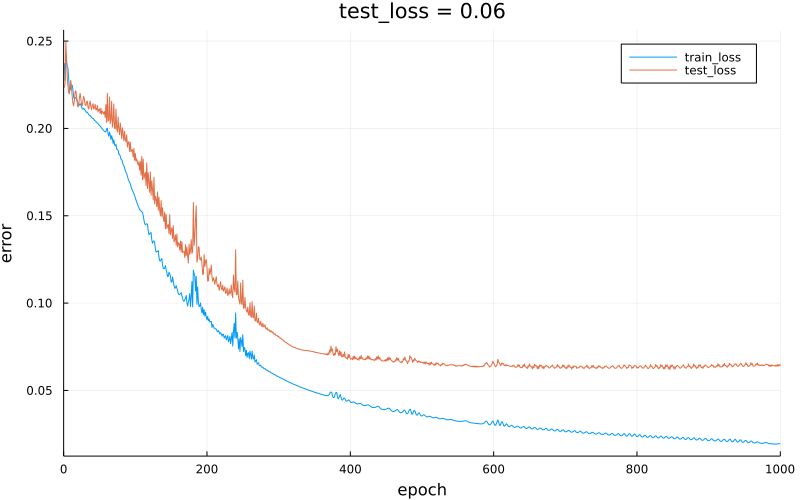

In [19]:
train_spiral(X, y)

We can now see that the model is having some difficulty closing the gap between the training error and the test error due to the noise. Try playing around with the model capacity (by changing the width of the hidden layer or by adding more layers) and also with different amounts of regularisation to see if you can reduce the test error further.